# Infomap
Infomap is a stochastic network clustering algorithm based on minimizing the [Map equation](http://www.mapequation.org/publications.html#Rosvall-Axelsson-Bergstrom-2009-Map-equation).


### The Map Equation

\begin{equation*}
    L(M) = q_\curvearrowright H(\mathcal{Q}) + \sum_{i = 1}^{m}{p_{\circlearrowright}^i H(\mathcal{P}^i)}
\end{equation*}

$L(M)$ measures the amount of information it takes to describe a random walk on a network given a partition of the network into modules $M$. It is a sum of the amount of information needed to describe the movements _between_ and _within_ the modules, which balances the goodness of fit with the complexity of the model. For more information, see [www.mapequation.org](http://www.mapequation.org).

### Features

Infomap supports
* Unweighted and weighted links
* Undirected and directed links
* Two-level and multi-level solutions
* First-order and second-order dynamics
* Hard partitions and overlapping partitions
* Single- and multi-layer networks

## Getting started
See https://mapequation.github.io/infomap/ for a simple example and python API to get started with Infomap in python

### Install Infomap

The v1.0 beta release is available on the PyPI, install it with
```
pip install infomap
```
or upgrade with
```
pip install --upgrade infomap
```

In [1]:
import infomap
print(infomap.Infomap().version)

1.0.0-beta.14


## Basic command line use
The installation of the python package also installs a binary for command line use, exemplified below.
See http://www.mapequation.org/code.html#Options for available input flags to `Infomap`

**TODO:** Try run the command line version of Infomap installed with the python package. Command line programs can be called directly from jupyter by adding `!` in front, like `!ls`. Run Infomap on the `ninetriangles.net` network in the `data` folder and direct output to the `output` folder. Run it with `5` trials to see the effect of the stochastic nature of Infomap.

In [2]:
!infomap data/ninetriangles.net output/ -N5

  Infomap v1.0.0-beta.14 starts at [2018-08-30 18:15:10]
  -> Input network: data/ninetriangles.net
  -> Output path:   output/
  -> Configuration: num-trials = 5
Parsing undirected network from file 'data/ninetriangles.net'... 
   Parsing vertices...
   -> 27 physical nodes added
   Parsing links...
   -> 39 links
Done!
-------------------------------------
  -> 27 state nodes
  -> 27 physical nodes
  -> 39 links with total weight 39
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sumLinkFlow: 1
Build internal network...
Generate network with 27 nodes and 39 links...
Calculating one-level codelength... done!
 -> One-level codelength: 4.74543683

Trial 1/5 starting at[2018-08-30 18:15:10]
Two-level compression: 25% 5e-14% 
Partitioned to codelength 0.641526923 + 2.92289551 = 3.564422432 in 7 modules.
Super-level compression: to codeleng

### Input network
The input network above was formed as nine triangles clustered in three levels, which was also recovered with the Infomap clustering algorithm after some trials.

![triangle-network](http://www.mapequation.org/assets/img/triangle-network-levels_3.svg)

In [3]:
from pathlib import Path
print(Path('data/ninetriangles.net').read_text())

*Vertices 27
 1 "1"
 2 "2"
 3 "3"
 4 "4"
 5 "5"
 6 "6"
 7 "7"
 8 "8"
 9 "9"
 10 "10"
 11 "11"
 12 "12"
 13 "13"
 14 "14"
 15 "15"
 16 "16"
 17 "17"
 18 "18"
 19 "19"
 20 "20"
 21 "21"
 22 "22"
 23 "23"
 24 "24"
 25 "25"
 26 "26"
 27 "27"
*Edges 39
1 2 1
1 3 1
1 4 1
2 3 1
3 7 1
4 5 1 
4 6 1 
5 6 1 
6 8 1 
7 8 1 
7 9 1 
8 9 1 
10 11 1
10 12 1
10 13 1
11 12 1
12 16 1
13 14 1 
13 15 1 
14 15 1 
15 17 1 
16 17 1 
16 18 1 
17 18 1
19 20 1
19 21 1
19 22 1
20 21 1
21 25 1
22 23 1 
22 24 1 
23 24 1 
24 26 1 
25 26 1 
25 27 1 
26 27 1
9 20 1
5 11 1
18 23 1


### Output format
By default on command line, Infomap writes an output file with the same name as the input by with the `.tree` extension. This file contains the multi-level modular structure of the input network.

In [4]:
print(Path('output/ninetriangles.tree').read_text())

# Codelength = 3.48419 bits.
# path flow name physicalId
1:1:1 0.0384615 "1" 1
1:1:2 0.025641 "2" 2
1:1:3 0.0384615 "3" 3
1:2:1 0.0384615 "4" 4
1:2:2 0.0384615 "5" 5
1:2:3 0.0384615 "6" 6
1:3:1 0.0384615 "7" 7
1:3:2 0.0384615 "8" 8
1:3:3 0.0384615 "9" 9
2:1:1 0.0384615 "10" 10
2:1:2 0.0384615 "11" 11
2:1:3 0.0384615 "12" 12
2:2:1 0.0384615 "13" 13
2:2:2 0.025641 "14" 14
2:2:3 0.0384615 "15" 15
2:3:1 0.0384615 "16" 16
2:3:2 0.0384615 "17" 17
2:3:3 0.0384615 "18" 18
3:1:1 0.0384615 "19" 19
3:1:2 0.0384615 "20" 20
3:1:3 0.0384615 "21" 21
3:2:1 0.0384615 "22" 22
3:2:2 0.0384615 "23" 23
3:2:3 0.0384615 "24" 24
3:3:1 0.0384615 "25" 25
3:3:2 0.0384615 "26" 26
3:3:3 0.025641 "27" 27



## From Python
The python API gives more flexibility, but we can still work with files in a similar way as the cli use above.

In [5]:
infomapFileIO = infomap.Infomap("-N5")

# Read from file
infomapFileIO.network().readInputData("data/ninetriangles.net")

infomapFileIO.run()

print("Clustered in {} levels with codelength {}".format(infomapFileIO.maxTreeDepth(), infomapFileIO.codelength()))

print("Writing result to file...")
infomapFileIO.writeClu("output/ninetriangles.clu")
infomapFileIO.writeFlowTree("output/ninetriangles.ftree")
print("Done!")

print("\n.ftree file:")
print(Path('output/ninetriangles.ftree').read_text())

Clustered in 3 levels with codelength 3.4841898804052187
Writing result to file...
Done!

.ftree file:
# Codelength = 3.48419 bits.
# path flow name physicalId
1:1:1 0.0384615 "1" 1
1:1:2 0.025641 "2" 2
1:1:3 0.0384615 "3" 3
1:2:1 0.0384615 "4" 4
1:2:2 0.0384615 "5" 5
1:2:3 0.0384615 "6" 6
1:3:1 0.0384615 "7" 7
1:3:2 0.0384615 "8" 8
1:3:3 0.0384615 "9" 9
2:1:1 0.0384615 "10" 10
2:1:2 0.0384615 "11" 11
2:1:3 0.0384615 "12" 12
2:2:1 0.0384615 "13" 13
2:2:2 0.025641 "14" 14
2:2:3 0.0384615 "15" 15
2:3:1 0.0384615 "16" 16
2:3:2 0.0384615 "17" 17
2:3:3 0.0384615 "18" 18
3:1:1 0.0384615 "19" 19
3:1:2 0.0384615 "20" 20
3:1:3 0.0384615 "21" 21
3:2:1 0.0384615 "22" 22
3:2:2 0.0384615 "23" 23
3:2:3 0.0384615 "24" 24
3:3:1 0.0384615 "25" 25
3:3:2 0.0384615 "26" 26
3:3:3 0.025641 "27" 27
*Links undirected
#*Links path exitFlow numEdges numChildren
*Links root 0 3 3
1 2 0.025641
1 3 0.025641
2 3 0.025641
*Links 1 0.0512821 3 3
1 2 0.025641
1 3 0.025641
2 3 0.025641
*Links 1:1 0.0512821 3 3
1 2 0.02

## Basic programmatic use

In [6]:
infomap1 = infomap.Infomap("--directed")

# Use the default network, which got configured as directed by Infomap
network = infomap1.network()

# Add link weight as an optional third argument
network.addLink(0, 1)
network.addLink(0, 2)
network.addLink(0, 3)
network.addLink(1, 0)
network.addLink(1, 2)
network.addLink(2, 1)
network.addLink(2, 0)
network.addLink(3, 0)
network.addLink(3, 4)
network.addLink(3, 5)
network.addLink(4, 3)
network.addLink(4, 5)
network.addLink(5, 4)
network.addLink(5, 3)

infomap1.run()

print("Found {} top modules with codelength {}".format(infomap1.numTopModules(), infomap1.codelength()))

print("\nResult tree:\n#path flow [nodeId]")
for node in infomap1.iterTree():
    if node.isLeaf():
        print("{} {} {}".format(node.path(), node.data.flow, node.stateId))
    else:
        print("{} {}".format(node.path(), node.data.flow))

Found 2 top modules with codelength 2.320730356833789

Result tree:
#path flow [nodeId]
() 0.9999999999999996
(0,) 0.4999999999999998
(0, 0) 0.2142857142857142 0
(0, 1) 0.1428571428571428 1
(0, 2) 0.1428571428571428 2
(1,) 0.4999999999999998
(1, 0) 0.2142857142857142 3
(1, 1) 0.1428571428571428 4
(1, 2) 0.1428571428571428 5


## Infomap + NetworkX
Generate and draw a network with NetworkX, colored
according to the community structure found by Infomap.

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors

Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 3 modules with codelength: 4.311792645801829


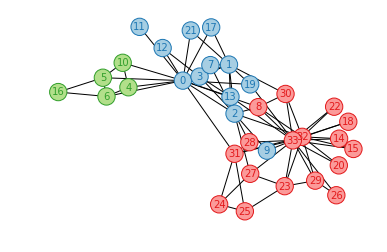

In [8]:
def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    infomapX = infomap.Infomap("--two-level")

    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges():
        infomapX.network().addLink(*e)

    print("Find communities with Infomap...")
    infomapX.run();

    print("Found {} modules with codelength: {}".format(infomapX.numTopModules(), infomapX.codelength()))

    communities = {}
    for node in infomapX.iterLeafNodes():
        communities[node.physicalId] = node.moduleIndex()

    nx.set_node_attributes(G, values=communities, name='community')

def drawNetwork(G):
    # position map
    pos = nx.spring_layout(G)
    # community ids
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    numCommunities = max(communities) + 1
    # color map from http://colorbrewer2.org/
    cmapLight = colors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', numCommunities)
    cmapDark = colors.ListedColormap(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', numCommunities)

    # Draw edges
    nx.draw_networkx_edges(G, pos)

    # Draw nodes
    nodeCollection = nx.draw_networkx_nodes(G,
        pos = pos,
        node_color = communities,
        cmap = cmapLight
    )
    # Set node border color to the darker shade
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)

    # Draw node labels
    for n in G.nodes():
        plt.annotate(n,
            xy = pos[n],
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            xytext = [0, 0],
            color = cmapDark(communities[n])
        )

    plt.axis('off')
    # plt.savefig("karate.png")
    plt.show()

G=nx.karate_club_graph()

findCommunities(G)

drawNetwork(G)

## Higher-order networks

### General state networks
The [state format](http://www.mapequation.org/code.html#State-format) describes the exact network used internally by Infomap. It can model both ordinary networks and memory networks (of variable order).

#### Example
```
*Vertices 4
1 "PRE"
2 "SCIENCE"
3 "PRL"
4 "BIO"
# *ngrams
# 1 2 3
# 1 2 2 3
# 4 2 4
*States
#stateId physicalId [name]
1 2 "1 2"
2 3 "2 3"
3 2 "1 2 2"
4 2 "4 2"
5 4 "2 4"
*Links
1 2
3 2
4 5
```
Here some ngrams are represented by ordinary links between a set of state nodes.

#### Programmatically creating a state network

In [9]:
infomapStates = infomap.Infomap("")

network = infomapStates.network()

# network.readInputData(filename)

network.addPhysicalNode(1, "PRE")
network.addPhysicalNode(2, "SCIENCE")
network.addPhysicalNode(3, "PRL")
network.addPhysicalNode(4, "BIO")

network.addStateNode(1, 2)
network.addStateNode(2, 3)
network.addStateNode(3, 2)
network.addStateNode(4, 2)
network.addStateNode(5, 4)

network.addLink(1, 2)
network.addLink(3, 2)
network.addLink(4, 5)

infomapStates.run()

print("Found {} top modules with codelength: {}".format(infomapStates.numTopModules(), infomapStates.codelength()))

print("\n#stateId physicalId moduleIndex flow")
for node in infomapStates.iterTree():
    if node.isLeaf():
        print("{} {} {} {}".format(node.stateId, node.physicalId, node.moduleIndex(), node.data.flow))

print("\nIterate over physical nodes to get the overlapping physical module structure:")
print("#physicalId moduleIndex flow")
for node in infomapStates.iterTreePhysical():
    if node.isLeaf():
        print("{} {} {}".format(node.physicalId, node.moduleIndex(), node.data.flow))

print("\nNote that state nodes 1 and 3 within module 0 is part of the same physical node 2 and merged above")

Found 2 top modules with codelength: 1.3333333333333364

#stateId physicalId moduleIndex flow
1 2 0 0.16666666666666666
2 3 0 0.3333333333333333
3 2 0 0.16666666666666666
4 2 1 0.16666666666666666
5 4 1 0.16666666666666666

Iterate over physical nodes to get the overlapping physical module structure:
#physicalId moduleIndex flow
2 0 0.3333333333333333
3 0 0.3333333333333333
2 1 0.16666666666666666
4 1 0.16666666666666666

Note that state nodes 1 and 3 within module 0 is part of the same physical node 2 and merged above


### paths

Infomap can generate a higher-order state network from path data, specifying a certain markov order. Markov order 1 corresponds to an ordinary network where the memory is discarded.

In [10]:
infomapPaths = infomap.Infomap("")

network = infomapPaths.network()

markovOrder = 2
network.addPath([1, 2, 3], markovOrder, 1.0)
network.addPath([1, 2, 3, 4, 5], markovOrder, 1.0)
network.addPath([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], markovOrder, 2.0)
network.addPath([4, 3, 2, 1], markovOrder, 3.0)
network.addPath([1, 2, 3], markovOrder, 1.0)
network.addPath([3, 2, 1], markovOrder, 1.0)

# Write state network that can be loaded more efficiently later instead of the paths data
network.writeStateNetwork("output/paths_states.net")

print("Generated state network with {} nodes and {} links".format(network.numNodes(), network.numLinks()))

print("Run Infomap on network...")
infomapPaths.run()

print("Found {} top modules with codelength: {}".format(infomapPaths.numTopModules(), infomapPaths.codelength()))

print("\n#physicalId moduleIndex flow")
for node in infomapPaths.iterTreePhysical():
    if node.isLeaf():
        print("{} {} {}".format(node.physicalId, node.moduleIndex(), node.data.flow))

print("\nHere physical nodes 2 and 3 have overlapping modules")

Generated state network with 12 nodes and 10 links
Run Infomap on network...
Found 4 top modules with codelength: 2.36460845871456

#physicalId moduleIndex flow
2 0 0.08928571428571429
3 0 0.14285714285714285
4 0 0.10714285714285714
5 0 0.08928571428571427
6 1 0.07142857142857142
7 1 0.07142857142857142
8 2 0.07142857142857142
9 2 0.07142857142857142
10 2 0.03571428571428571
1 3 0.07142857142857142
2 3 0.125
3 3 0.05357142857142857

Here physical nodes 2 and 3 have overlapping modules


#### Running on the generated state network will give the same result

In [11]:
infomapStates2 = infomap.Infomap("")

infomapStates2.network().readInputData("output/paths_states.net")
infomapStates2.run()

print("Found {} top modules with codelength: {}".format(infomapPaths.numTopModules(), infomapPaths.codelength()))

print("\n#physicalId moduleIndex flow")
for node in infomapStates2.iterTreePhysical():
    if node.isLeaf():
        print("{} {} {}".format(node.physicalId, node.moduleIndex(), node.data.flow))

Found 4 top modules with codelength: 2.36460845871456

#physicalId moduleIndex flow
2 0 0.08928571428571429
3 0 0.14285714285714285
4 0 0.10714285714285714
5 0 0.08928571428571427
6 1 0.07142857142857142
7 1 0.07142857142857142
8 2 0.07142857142857142
9 2 0.07142857142857142
10 2 0.03571428571428571
1 3 0.07142857142857142
2 3 0.125
3 3 0.05357142857142857
